In [46]:
%matplotlib inline  
import pandas as pd
import numpy as np
import scipy as sp
import io
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import decomposition
from scipy import io
import bisect
from oasis import *
import cPickle as pickle
import os
import gzip

## Dataset loading...

In [72]:
mode = 'facile'
dataset_train = 'data_train_' + mode + '.mat'
dataset_test = 'data_test_' + mode + '.mat'

In [73]:
train_facile = io.loadmat('data/' + dataset_train)
print(train_facile.keys())
print(train_facile['X'].dtype)
print(train_facile['X'].shape)
print(train_facile['label'].shape)
print(np.unique(train_facile['label']).shape)

['X', 'label', '__version__', '__header__', '__globals__']
float32
(312022, 1500)
(312022, 1)
(203513,)


## Generate pairs

In [74]:
def generate_pairs(label, n_pairs, positive_ratio, random_state=42):
    """Generate a set of pair indices
    
    Parameters
    ----------
    label : array, shape (n_samples, 1)
        Label vector
    n_pairs : int
        Number of pairs to generate
    positive_ratio : float
        Positive to negative ratio for pairs
    random_state : int
        Random seed for reproducibility
        
    Output
    ------
    pairs_idx : array, shape (n_pairs, 2)
        The indices for the set of pairs
    label_pairs : array, shape (n_pairs, 1)
        The pair labels (+1 or -1)
    """
    rng = np.random.RandomState(random_state)
    n_samples = label.shape[0]
    pairs_idx = np.zeros((n_pairs, 2), dtype=int)
    pairs_idx[:, 0] = rng.randint(0, n_samples, n_pairs)
    rand_vec = rng.rand(n_pairs)
    for i in range(n_pairs):
        if rand_vec[i] <= positive_ratio:
            idx_same = np.where(label == label[pairs_idx[i, 0]])[0]
            idx2 = rng.randint(idx_same.shape[0])
            pairs_idx[i, 1] = idx_same[idx2]
        else:
            idx_diff = np.where(label != label[pairs_idx[i, 0]])[0]
            idx2 = rng.randint(idx_diff.shape[0])
            pairs_idx[i, 1] = idx_diff[idx2]
    pairs_label = 2.0 * (label[pairs_idx[:, 0]] == label[pairs_idx[:, 1]]) - 1.0
    return pairs_idx, pairs_label

pairs_idx, pairs_label = generate_pairs(train_facile['label'], 1500, 0.1)

## Compute distance

In [78]:
  
def euc_dist_pairs(X, pairs, batch_size=10000):
    """Compute an array of Euclidean distances between points indexed by pairs

    To make it memory-efficient, we compute the array in several batches.
    
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        Data matrix
    pairs : array, shape (n_pairs, 2)
        Pair indices
    batch_size : int
        Batch size (the smaller, the slower but less memory intensive)
        
    Output
    ------
    dist : array, shape (n_pairs,)
        The array of distances
    """
    n_pairs = pairs.shape[0]
    dist = np.ones((n_pairs,), dtype=np.dtype("float32"))
    for a in range(0, n_pairs, batch_size):
        b = min(a + batch_size, n_pairs)
        dist[a:b] = np.sqrt(np.sum((X[pairs[a:b, 0], :] - X[pairs[a:b, 1], :]) ** 2, axis=1))
    return dist
              

def cosine_dist_pairs(X, pairs, batch_size=10000):
    """Compute an array of Cosine distances between points indexed by pairs

    To make it memory-efficient, we compute the array in several batches.
    
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        Data matrix
    pairs : array, shape (n_pairs, 2)
        Pair indices
    batch_size : int
        Batch size (the smaller, the slower but less memory intensive)
        
    Output
    ------
    dist : array, shape (n_pairs,)
        The array of distances
    """
    n_pairs = pairs.shape[0]
    dist = np.ones((n_pairs,), dtype=np.dtype("float32"))
    for a in range(0, n_pairs, batch_size):
        b = min(a + batch_size, n_pairs)
        a_val = X[pairs[a:b, 0], :]
        b_val = X[pairs[a:b, 1], :]
        dist[a:b] = (np.sum(a_val * b_val, axis=1)) / (np.sqrt(np.sum((a_val) ** 2, axis=1)) * np.sqrt(np.sum((b_val) ** 2, axis=1)))
    return dist

def mahalanobis_dist_pairs(X, pairs, M, batch_size=10000):
    """Compute an array of mahalanobis distances between points indexed by pairs

    To make it memory-efficient, we compute the array in several batches.
    
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        Data matrix
    pairs : array, shape (n_pairs, 2)
        Pair indices
    batch_size : int
        Batch size (the smaller, the slower but less memory intensive)
        
    Output
    ------
    dist : array, shape (n_pairs,)
        The array of distances
    """
    n_pairs = pairs.shape[0]
    dist = np.ones((n_pairs,), dtype=np.dtype("float32"))
    for a in range(0, n_pairs, batch_size):
        b = min(a + batch_size, n_pairs)
        a_val = X[pairs[a:b, 0], :]
        b_val = X[pairs[a:b, 1], :]
        diff = a_val - b_val
        dist[a:b] = np.sum(np.dot(M, diff.T) * diff.T, axis=0)
    return dist

def psd_proj(M):
    """ projection de la matrice M sur le cone des matrices semi-definies
    positives"""
    # calcule des valeurs et vecteurs propres
    eigenval, eigenvec = np.linalg.eigh(M)
    # on trouve les valeurs propres negatives ou tres proches de 0
    ind_pos = eigenval > 1e-10
    # on reconstruit la matrice en ignorant ces dernieres
    M = np.dot(eigenvec[:, ind_pos] * eigenval[ind_pos][np.newaxis, :],
               eigenvec[:, ind_pos].T)
    return M

def hinge_loss_pairs(X, pairs_idx, y_pairs, M):
    """Calcul du hinge loss sur les paires
    """
    diff = X[pairs_idx[:, 0], :] - X[pairs_idx[:, 1], :]
    return np.maximum(0.0, 1.0 + y_pairs.T * (np.sum(
                                 np.dot(M, diff.T) * diff.T, axis=0) - 2.0))

def sgd_metric_learning(X, y, gamma, n_iter, n_eval, M_ini, random_state=42):
    """Stochastic gradient algorithm for metric learning
    
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,)
        The targets.
    gamma : float | callable
        The step size. Can be a constant float or a function
        that allows to have a variable step size
    n_iter : int
        The number of iterations
    n_eval : int
        The number of pairs to evaluate the objective function
    M_ini : array, shape (n_features,n_features)
        The initial value of M
    random_state : int
        Random seed to make the algorithm deterministic
    """
    rng = np.random.RandomState(random_state)
    n_samples = X.shape[0]
    n_features = X.shape[1]
    
    # pour eviter d'evaluer le risque sur toutes les paires possibles
    # on tire n_eval paires aleatoirement
    pairs_idx = rng.randint(0, n_samples, (n_eval, 2))
    # calcul du label des paires
    y_pairs = 2.0 * (y[pairs_idx[:, 0]] == y[pairs_idx[:, 1]]) - 1.0
    M = M_ini.copy()
    pobj = np.zeros(n_iter)
    
    if not callable(gamma):
        # Turn gamma to a function
        gamma_func = lambda t: gamma
    else:
        gamma_func = gamma

    for t in range(n_iter):
        pobj[t] = np.mean(hinge_loss_pairs(X, pairs_idx, y_pairs, M))
        gradient = np.zeros((n_features,n_features))
        pairs_idx2 = rng.randint(0, n_samples, (1, 2))
        y_pairs2 = 2.0 * (y[pairs_idx2[:, 0]] == y[pairs_idx2[:, 1]]) - 1.0
        if hinge_loss_pairs(X, pairs_idx2, y_pairs2, M)[0] != 0.:
            Xt = np.reshape(X[pairs_idx2[0,0],:] - X[pairs_idx2[0,1],:],(4,1))
            gradient = y_pairs2*np.dot(Xt,Xt.T)
        M -= gamma_func(t) * gradient
        M = psd_proj(M)
    return M, pobj

def braycurtis_dist_pairs(X, pairs, batch_size=10000):
    n_pairs = pairs.shape[0]
    dist = np.ones((n_pairs,), dtype=np.dtype("float32"))
    for a in range(0, n_pairs, batch_size):
        b = min(a + batch_size, n_pairs)
        a_val = X[pairs[a:b, 0], :]
        b_val = X[pairs[a:b, 1], :]
        dist[a:b] = [sp.spatial.distance.braycurtis(X[pairs[i,0], :], X[pairs[i,1], :]) for i in range(a,b)]
    return dist     
 
def M_lmnn(X, y):
    lmnn = LMNN(k=1, learn_rate=1e-6).fit(X,y, verbose=False)
    # Mahalanobis distance matrix
    M=lmnn.metric()
    np.savetxt('M_LMNN.txt',M)
    return M

def oasis_dist_pairs(X, pairs, M, batch_size=10000):
    n_pairs = pairs.shape[0]
    dist = np.ones((n_pairs,), dtype=np.dtype("float32"))
    for a in range(0, n_pairs, batch_size):
        b = min(a + batch_size, n_pairs)
        a_val = X[pairs[a:b, 0], :]
        b_val = X[pairs[a:b, 1], :]
        dist[a:b] = np.ones(b-a, dtype=np.float) - (np.sum(np.dot(M, a_val.T) * \
            b_val.T, axis=0)) / (np.sqrt(np.sum(np.dot(M, a_val.T) * \
                a_val.T, axis=0)) * np.sqrt(np.sum(np.dot(M, b_val.T) * \
                b_val.T, axis=0)))
    return dist     

'''
M = []
with open('tmp/oasis_matrix_facile_8000000.txt', 'r') as f:
    for line in f:
     M.append(float(line))
f.closed
'''
f = gzip.open('tmp/oasis_test/model0008.pklz', 'rb')
M = pickle.load(f)
M = np.array(M)
M = M.reshape((1500, 1500))
dist_oasis = -oasis_dist_pairs(train_facile['X'], pairs_idx, M)


dist_eucl = -euc_dist_pairs(train_facile['X'], pairs_idx)
dist_cosine = cosine_dist_pairs(train_facile['X'], pairs_idx)
dist_braycurtis = -braycurtis_dist_pairs(train_facile['X'], pairs_idx)
# mahalanobis with identity matrix
M_identity = np.identity(1500) 
dist_mahalanobis = -mahalanobis_dist_pairs(train_facile['X'], pairs_idx, M_identity)

# SGD matrix
# 1) down sample
train_facile_ds = train_facile['X'][::50] 
train_label_facile_ds = train_facile['label'][::50] 
# 2) pca
n_components = 200
pca = decomposition.PCA(n_components=n_components)
train_facile_ds_pca = pca.fit_transform(train_facile_ds)
# 3) SGD
n_features = train_facile_ds_pca.shape[1]
M_ini = np.eye(n_features)
M_SGD, _ = sgd_metric_learning(train_facile_ds_pca, train_label_facile_ds, 0.001, 10000, 1000, M_ini)
# 4) mahalanobis with SGD and down sample pca pairs
pairs_idx_pca, pairs_label_pca = generate_pairs(train_label_facile_ds, n_features, 0.1)
dist_mahalanobis_SGD = -mahalanobis_dist_pairs(train_facile_ds_pca, pairs_idx_pca, M_SGD)

## ROC curve

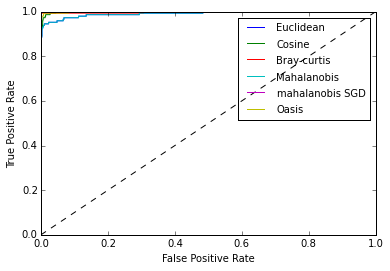

Euclidean distance score
0.123287671233
Cosine distance score
0.0958904109589
Braycurtis distance score
0.013698630137
Mahalanobis distance score
0.123287671233
Mahalanobis SGD distance score
0.0
Oasis distance score
0.041095890411


In [83]:
fpr_eucl, tpr_eucl, thresholds_eucl = metrics.roc_curve(pairs_label, dist_eucl)
fpr_cosine, tpr_cosine, thresholds_cosine = metrics.roc_curve(pairs_label, dist_cosine)
fpr_braycurtis, tpr_braycurtis, thresholds_braycurtis = metrics.roc_curve(pairs_label, dist_braycurtis)
fpr_mahalanobis, tpr_mahalanobis, thresholds_mahalanobis = metrics.roc_curve(pairs_label, dist_mahalanobis)
fpr_mahalanobis_SGD, tpr_mahalanobis_SGD, thresholds_mahalanobis_SGD = metrics.roc_curve(pairs_label_pca, dist_mahalanobis_SGD)
fpr_oasis, tpr_oasis, thresholds_oasis = metrics.roc_curve(pairs_label, dist_oasis)

plt.clf()
plt.plot(fpr_eucl, tpr_eucl, label='Euclidean')
plt.plot(fpr_cosine, tpr_cosine, label='Cosine')
plt.plot(fpr_braycurtis, tpr_braycurtis, label='Bray-curtis')
plt.plot(fpr_mahalanobis, tpr_mahalanobis, label='Mahalanobis')
plt.plot(fpr_mahalanobis_SGD, tpr_mahalanobis_SGD, label='mahalanobis SGD')
plt.plot(fpr_oasis, tpr_oasis, label='Oasis')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
legend = plt.legend(loc = 'upper right');
legend.prop.set_size(10);
plt.show()

# display score
print 'Euclidean distance score'
score_facile = 1.0 - tpr_eucl[bisect.bisect(fpr_eucl, 0.001) - 1]
print(score_facile)
print 'Cosine distance score'
score_facile = 1.0 - tpr_cosine[bisect.bisect(fpr_cosine, 0.001) - 1]
print(score_facile)
print 'Braycurtis distance score'
score_facile = 1.0 - tpr_braycurtis[bisect.bisect(fpr_braycurtis, 0.001) - 1]
print(score_facile)
print 'Mahalanobis distance score'
score_facile = 1.0 - tpr_mahalanobis[bisect.bisect(fpr_mahalanobis, 0.001) - 1]
print(score_facile)
print 'Mahalanobis SGD distance score'
score_facile = 1.0 - tpr_mahalanobis_SGD[bisect.bisect(fpr_mahalanobis_SGD, 0.001) - 1]
print(score_facile)
print 'Oasis distance score'
score_facile = 1.0 - tpr_oasis[bisect.bisect(fpr_oasis, 0.001) - 1]
print(score_facile)

## Generate output file

In [77]:
test_facile = io.loadmat('data/' + dataset_test)
print(test_facile.keys())
print(test_facile['X'].shape)

#dist_final = braycurtis_dist_pairs(test_facile['X'], test_facile['pairs'])
dist_final = oasis_dist_pairs(test_facile['X'], test_facile['pairs'], M)
#dist_final = -cosine_dist_pairs(test_facile['X'], test_facile['pairs'])

'''
pca = decomposition.PCA(n_components=n_features)
test_facile_pca = pca.fit_transform(test_facile['X'])
dist_final = -mahalanobis_dist_pairs(test_facile_pca, test_facile['pairs'], M_SGD)
'''

print dist_final.shape
np.savetxt('soumission_' + mode + '.txt', dist_final, fmt='%.5f')

['X', 'pairs', '__version__', '__header__', '__globals__']
(34673, 1500)
(213496,)
